In [1]:
import smrf
import laspy
import rasterio

import numpy as np
import matplotlib.pyplot as plt

In [2]:
fn = "data/USGS_LPC_VA_FEMA-NRCS_SouthCentral_2017_D17_17SNB23501450.las"
las = laspy.read(fn)

Laspy returns an object that you can use to access the portions you need.  However, accessing the xyz data directly doesn't always work, as you will receive a ScaledArrayView that may not work in every application, including smrf:

In [3]:
las.x

<ScaledArrayView([523500.45 523501.95 523504.33 ... 524990.53 524989.94 524984.31])>

However, if you wrap this in a standard numpy.array() call, you can re-organize it.

In [4]:
np.array(las.x)

array([523500.45, 523501.95, 523504.33, ..., 524990.53, 524989.94,
       524984.31])

In [5]:
# We'll do that, but with a condensed call that is faster than doing all three (xyz) separately:

Z,T,obj_cells,obj_array = smrf.smrf(*np.array((las.x,las.y,las.z)),cellsize=1,windows=5,
                                                slope_threshold=.15,elevation_threshold=.5,elevation_scaler=1.25,
                                                low_filter_slope=5,low_outlier_fill=False)

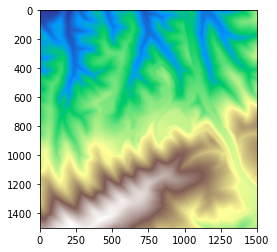

In [6]:
plt.imshow(Z,cmap='terrain')

In [7]:
# Write out smrf'ed DTM using rasterio

with rasterio.open('out/laspy.dtm.tif', 'w', driver='GTiff', 
                             height=Z.shape[0], width=Z.shape[1], crs="epsg:6346",
                             count=1, dtype=np.float32, transform=T) as src:
    src.write(Z.astype(np.float32), 1)

In [8]:
# We'll use the header from the original to save trouble, copy over the x,y,z coords and add the SMRFed 
# ground point classification. (SMRF returns a boolean vector of object points, so a little math to convert 
# to ASPRS standard 2-is-ground format.)

# Note: We are OVERWRITING the classification with this.  This may not be what you want to do!
las.classification[obj_array==0] = 2
las.classification[obj_array==1] = 1

#%% Export classified point cloud
new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
new_file.points = las.points
new_file.classification[obj_array==0] = 2
new_file.write('out/laspy.classified.las')